# Data Wrangling and EDA with Optimus, Pandas and Seaborn

In [1]:
from optimus import Optimus
op = Optimus()
df = op.load.excel("http://www.aussportsbetting.com/historical_data/nrl.xlsx", skiprows=1)

In [2]:
from pyspark.sql.functions import lit, row_number, last, desc, collect_list, first, ceil, col, year, hour, when, datediff, lag, sum, count, monotonically_increasing_id, date_format
from pyspark.sql.window import Window
from common_functions import name_changer, build_dict, get_record, get_time_between
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from operator import itemgetter
# colormap support from matplotlib
from matplotlib import cm 
#increase the number of rows and columns pandas prints 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType, FloatType
name_changer_udf = udf(name_changer, StringType())

df = df.withColumn("Home Team", name_changer_udf(col("Home Team"))) \
       .withColumn("Away Team", name_changer_udf(col("Away Team"))) \
       .withColumn("day_of_week", date_format('date', 'E')) \
        .filter(col("Play Off Game?")!="Y") \
        .withColumn("night_game", when(hour(col("Kick-off (local)"))>=17, 1).otherwise(0)) \
        .withColumn("game_index", monotonically_increasing_id()) \
        .withColumn("extra_time", when(col("Over Time?")=="Y", lit(1)).otherwise(lit(0)))
    

The dataset contained different names for the same teams, so the name_changer function just makes names consistent.

We also remove finals games, add a column which represents the day of week the game is played, and also a boolean variable which indicates whether a game was played before 5pm or not.

In [4]:
home_games = df.select(df["Home Team"].alias("team"), 
                       df["Home Score"].alias("score"),
                       df["Home Odds"].alias("odds"),
                       df["Away Team"].alias("opp_team"),
                       df["Away Score"].alias("opp_score"),
                       df["Away Odds"].alias("opp_odds"),
                       df["Date"].alias("date"), 
                       df["day_of_week"], 
                       df["night_game"], 
                       df["game_index"],
                       df["extra_time"],
                       df["Kick-off (local)"].alias("local_time")) \
                .withColumn("type", lit("home"))

In [5]:
home_games.table(5)

team 1 (string) nullable,score 2 (bigint) nullable,odds 3 (double) nullable,opp_team 4 (string) nullable,opp_score 5 (bigint) nullable,opp_odds 6 (double) nullable,date 7 (timestamp) nullable,day_of_week 8 (string) nullable,night_game 9 (int) not nullable,game_index 10 (bigint) not nullable,extra_time 11 (int) not nullable,local_time 12 (string) nullable,type 13 (string) not nullable
St.⋅George⋅Illawarra⋅Dragons,4,1.84,Parramatta⋅Eels,12,2.02,2019-08-04⋅00:00:00,Sun,0,0,0,16:05:00,home
Sydney⋅Roosters,58,1.11,Gold⋅Coast⋅Titans,6,6.8,2019-08-04⋅00:00:00,Sun,0,1,0,14:00:00,home
Cronulla-Sutherland⋅Sharks,39,1.94,South⋅Sydney⋅Rabbitohs,24,1.98,2019-08-03⋅00:00:00,Sat,1,2,0,19:35:00,home
Canterbury-Bankstown⋅Bulldogs,16,2.86,Penrith⋅Panthers,8,1.45,2019-08-03⋅00:00:00,Sat,1,3,0,17:30:00,home
Manly-Warringah⋅Sea⋅Eagles,30,1.41,Newcastle⋅Knights,6,3.06,2019-08-03⋅00:00:00,Sat,0,4,0,15:00:00,home


In [6]:
away_games = df.select(df["Away Team"].alias("team"), 
                       df["Away Score"].alias("score"),
                       df["Away Odds"].alias("odds"),
                       df["Home Team"].alias("opp_team"), 
                       df["Home Score"].alias("opp_score"),
                       df["Home Odds"].alias("opp_odds"),
                       df["Date"].alias("date"),
                       df["day_of_week"], 
                       df["night_game"], 
                       df["game_index"], 
                       df["extra_time"],
                       df["Kick-off (local)"].alias("local_time")) \
                .withColumn("type", lit("away")) 
    

In [7]:
games = home_games.union(away_games)

In [8]:
from datetime import datetime
start = datetime.utcnow()

get_record_udf = udf(get_record, IntegerType())
get_time_between_udf = udf(get_time_between, FloatType())

games = games \
    .withColumn("year", year(col("date"))) \
    .withColumn("points_awarded", 
                when(col("score")>col("opp_score"), 
                     lit(2)) \
                .otherwise(when(col("score")<col("opp_score"), 
                                            lit(0)) \
                           .otherwise(lit(1)))) \
    .sort(col("date"), col("local_time")) \
    .withColumn("rest", 
                datediff(col("date"), 
                         lag(col("date"), 1) \
                         .over(Window. \
                            partitionBy(col("team"), col("year")) \
                                        .orderBy(col("date"))))) \
    .withColumn("result",when(col("score")>col("opp_score"), lit(1)) \
            .otherwise(when(col("score")<col("opp_score"), 
                            lit(0)) \
                       .otherwise(np.nan))) \
    .withColumn("win",when(col("score")>col("opp_score"), lit(1)) \
            .otherwise(lit(0))) \
    .withColumn("loss",when(col("score")<col("opp_score"), lit(1)) \
            .otherwise(lit(0))) \
    .withColumn("draw",when(col("score")==col("opp_score"), lit(1)) \
            .otherwise(lit(0))) \
    .withColumn("record", collect_list(col("result"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date")))) \
    .withColumn("record_date", collect_list(col("date"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date")))) \
    .withColumn("record_extra_time", collect_list(col("extra_time"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date")))) \
    .withColumn("total_points", sum(col("points_awarded"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date"))) - col("points_awarded")) \
    .withColumn("total_points_after_game", sum(col("points_awarded"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date")))) \
    .withColumn("total_for", sum(col("score"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date"))) - col("score")) \
    .withColumn("total_for_after_game", sum(col("score"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date")))) \
    .withColumn("total_against", sum(col("opp_score"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date"))) - col("opp_score")) \
    .withColumn("total_against_after_game", sum(col("opp_score"))\
                 .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date")))) \
    .withColumn("total_for_per_game", col("total_for") / ((count("*") \
                .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date"))))-1) ) \
    .withColumn("total_against_per_game", col("total_against") / ((count("*") \
                .over(Window. \
                    partitionBy(col("team"), col("year")) \
                                .orderBy(col("date"))))-1) ) \
    .withColumn("total_diff_per_game", col("total_for_per_game") - col("total_against_per_game")) \
    .withColumn("total_diff", col("total_for") - col("total_against")) \
    .withColumn("total_diff_after_game", col("total_for_after_game") - col("total_against_after_game")) \
    .withColumn("time_from_last_win", get_time_between_udf(col("record"), col("record_date"), col("date"), lit("win"))) \
    .withColumn("time_from_last_extra_time_game", get_time_between_udf(col("record_extra_time"), col("record_date"), col("date"), lit("win"))) \
    .withColumn("time_from_last_loss", get_time_between_udf(col("record"), col("record_date"), col("date"), lit("loss"))) \
    .withColumn("time_from_last_draw", get_time_between_udf(col("record"), col("record_date"), col("date"))) \
    .withColumn("wins_in_a_row", get_record_udf(col("record"), lit(True))) \
    .withColumn("losses_in_a_row", get_record_udf(col("record"), lit(False)))
    
end = datetime.utcnow()

print("Time taken to add columns: {}".format((end - start).total_seconds()))

Time taken to add columns: 1.303941


In [9]:
pgames = games.toPandas().sort_values(['game_index'], ascending=False).reset_index(drop=True)

In [10]:
start = datetime.utcnow() 
for index, row in pgames.iterrows():
    if (index-16) < 0 or row['date'].year != pgames.loc[(index-16), 'date'].year: 
        pgames.loc[index, 'position'] = np.nan
    else:
        table = []
        for reindex in range(index-1, -1, -1):
            if row['date'].year != pgames.loc[reindex, 'date'].year or len(table)==16:
                break
            elif row['game_index']==pgames.loc[reindex, 'game_index'] or pgames.loc[reindex, 'team'] in [i['team'] for i in table]:
                continue
            else:
                team_pos = {}
                team_pos['team'] = pgames.loc[reindex, 'team']
                team_pos['points'] = pgames.loc[reindex, 'total_points_after_game']
                team_pos['diff'] = pgames.loc[reindex, 'total_diff_after_game']
                table.append(team_pos)
        table = sorted(table, key=itemgetter('points', 'diff'), reverse=True)
        info_by_team = build_dict(table, key='team')
        pgames.loc[index, 'position'] = info_by_team[row['team']]['index'] + 1

end=datetime.utcnow()
print("Time taken to add columns: {}".format((end - start).total_seconds()))

Time taken to add columns: 12.285517


In [11]:
start = datetime.utcnow() 
for index, row in pgames.iterrows():
    if (index-16) < 0 or row['date'].year != pgames.loc[(index-16), 'date'].year: 
        pgames.loc[index, 'position'] = np.nan
    else:
        table = []
        for reindex in range(index, -1, -1):
            if row['date'].year != pgames.loc[reindex, 'date'].year or len(table)==16:
                break
            elif pgames.loc[reindex, 'team'] in [i['team'] for i in table]:
                continue
            else:
                team_pos = {}
                team_pos['team'] = pgames.loc[reindex, 'team']
                team_pos['points'] = pgames.loc[reindex, 'total_points_after_game']
                team_pos['diff'] = pgames.loc[reindex, 'total_diff_after_game']
                table.append(team_pos)
        table = sorted(table, key=itemgetter('points', 'diff'), reverse=True)
        info_by_team = build_dict(table, key='team')
        pgames.loc[index, 'position_after_game'] = info_by_team[row['team']]['index'] + 1

end=datetime.utcnow()
print("Time taken to add columns: {}".format((end - start).total_seconds()))

Time taken to add columns: 10.179779


In [12]:
games = op.create \
          .df(pdf=pgames) \
          .withColumn("ranking_quantile", 
                      when(col("position")!=np.nan,
                           ceil(col("position")/4)) \
                      .otherwise(np.nan)) \
            .withColumn("opp_position", sum(col("position")) \
                        .over(Window.partitionBy("game_index")) - col("position")) \
            .withColumn("opp_ranking_quantile", 
                      when(col("opp_position")!=np.nan,
                           ceil(col("opp_position")/4)) \
                      .otherwise(np.nan)) \
            .withColumn("previous_opp_position", 
                       lag(col("opp_position"), 1) \
                       .over(Window.partitionBy("team").orderBy(col("game_index")))) \
            .withColumn("previous_opp_ranking_quantile", 
                      when(col("previous_opp_position")!=np.nan,
                           ceil(col("previous_opp_position")/4)) \
                      .otherwise(np.nan)) \
            .withColumn("previous_result", 
                       lag(col("points_awarded"), 1) \
                       .over(Window.partitionBy("team").orderBy(col("game_index")))) \
            .withColumn("previous_result_ranking", col("previous_result")*col("previous_opp_ranking_quantile"))

In [13]:
home_games = games \
    .filter(col("type")=="home") \
    .select(col("team").alias("home_team"),
            col("odds").alias("home_odds"),
            col("opp_team").alias("opp_away_team"),
            col("score").alias("home_score"), 
            col("date"), 
            col("local_time"),
            col("day_of_week"),
            col("night_game"),
            col("game_index"),
            col("wins_in_a_row").alias("home_wins_in_a_row"),
            col("losses_in_a_row").alias("home_losses_in_a_row"),
            col("position").alias("home_position"),
            col("ranking_quantile").alias("home_ranking_quantile"),
            col("total_points").alias("home_points"),
            col("total_for_per_game").alias("home_for_per_game"),
            col("total_against_per_game").alias("home_against_per_game"),
            col("previous_result_ranking").alias("home_previous_result"),
            col("time_from_last_win").alias("home_time_from_last_win"),
            col("time_from_last_extra_time_game").alias("home_time_from_last_extra_time_game"),
            col("time_from_last_loss").alias("home_time_from_last_loss"),
            col("time_from_last_draw").alias("home_time_from_last_draw"),
            col("rest").alias("home_rest"))

away_games = games \
    .filter(col("type")=="away") \
    .select(col("team").alias("away_team"), 
            col("odds").alias("away_odds"),
            col("opp_team").alias("opp_home_team"),
            col("score").alias("away_score"), 
            col("position").alias("away_position"),
            col("total_points").alias("away_points"),
            col("wins_in_a_row").alias("away_wins_in_a_row"),
            col("losses_in_a_row").alias("away_losses_in_a_row"),
            col("ranking_quantile").alias("away_ranking_quantile"),
            col("total_for_per_game").alias("away_for_per_game"),
            col("total_against_per_game").alias("away_against_per_game"),
            col("rest").alias("away_rest"),
            col("previous_result_ranking").alias("away_previous_result"),
            col("time_from_last_win").alias("away_time_from_last_win"),
            col("time_from_last_extra_time_game").alias("away_time_from_last_extra_time_game"),
            col("time_from_last_loss").alias("away_time_from_last_loss"),
            col("time_from_last_draw").alias("away_time_from_last_draw"),
            col("date").alias("away_date"))
    

In [14]:
df = home_games.join(away_games, (home_games['home_team']==away_games['opp_home_team']) & \
                                 (home_games['opp_away_team']==away_games['away_team']) & \
                                 (home_games['date']==away_games['away_date'])) \
               .drop("opp_away_team", "opp_home_team", "away_date") \
               .withColumn("rest_spread", col("home_rest") - col("away_rest")) \
               .withColumn("game_id", monotonically_increasing_id()) \
                .withColumn("home_win",when(col("home_score")>col("away_score"), lit(1)) \
                            .otherwise(when(col("home_score")<col("away_score"), 
                                            lit(0)) \
                                       .otherwise(np.nan))) \
                .withColumn("winner",when(col("home_score")>col("away_score"), lit("home")) \
                            .otherwise(when(col("home_score")<col("away_score"), 
                                            lit("away")) \
                                       .otherwise("draw"))) \
                .withColumn("margin", col("home_score")-col("away_score")) \
                .withColumn("year", year(col("date"))) \
                .withColumn("hour", hour(col("local_time"))) \
                .withColumn("game_id_season", row_number().over(Window.partitionBy(col("year")).orderBy(col("date")))) \
                .withColumn("first_round", when(col("game_id_season")<=8, lit(1)).otherwise(lit(0))) \
                .withColumn("second_round", when((col("game_id_season")<=16) & (col("game_id_season")>8), lit(1)).otherwise(lit(0)))

In [15]:
pdf = df.toPandas()

In [16]:
pdf.sort_values(['date'], inplace=True)

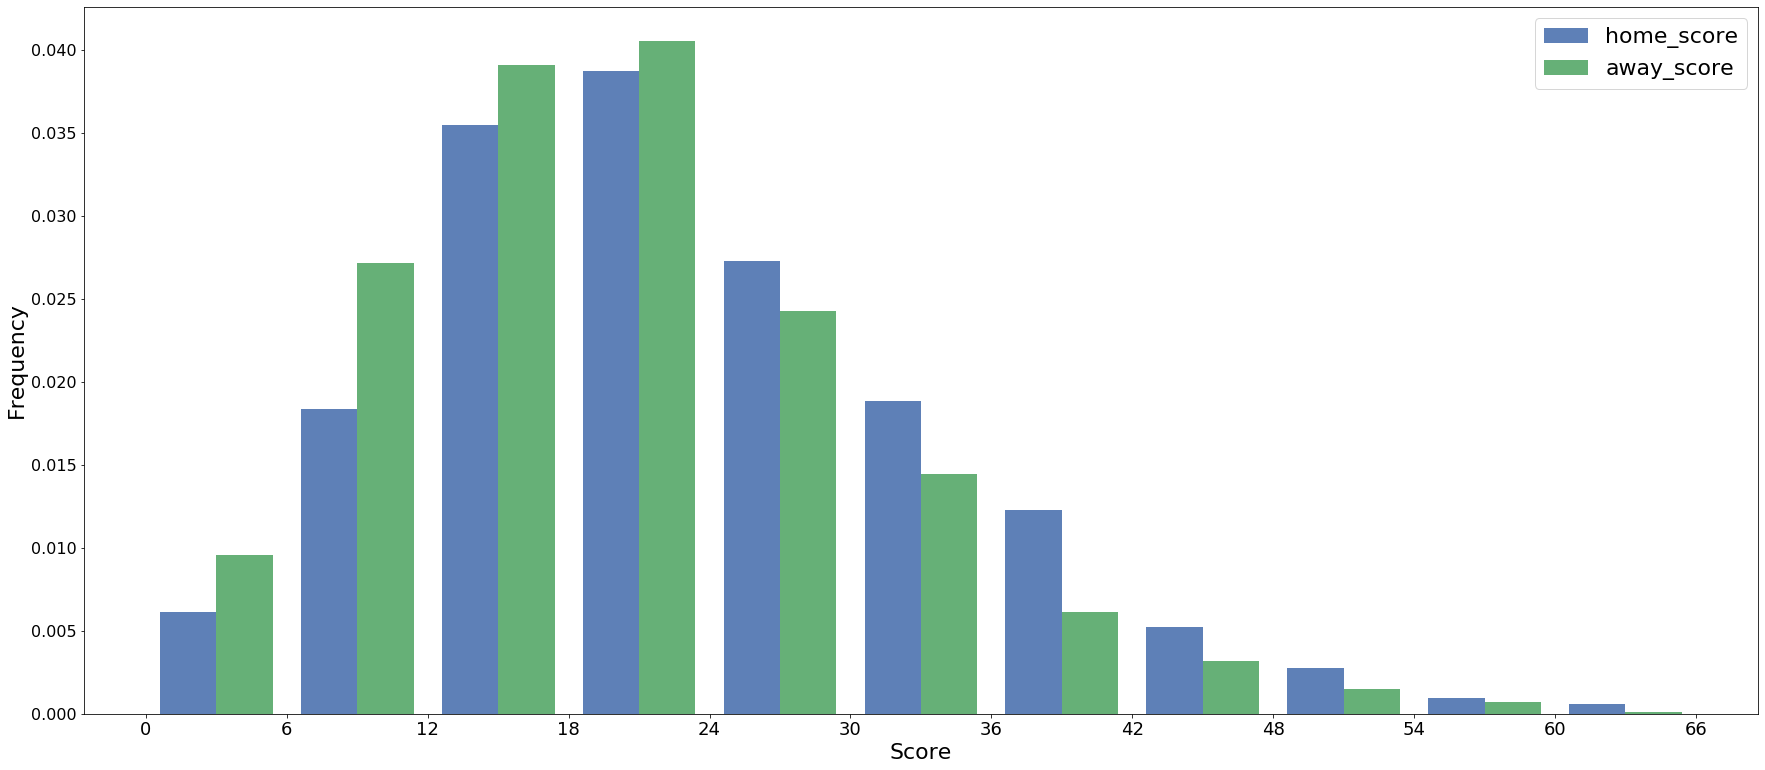

In [22]:
import numpy as np

data = np.vstack([pdf['home_score'], pdf['away_score']]).T
plt.style.use('seaborn-deep')
plt.figure(figsize=(30,13))
plt.hist(data, np.arange(0,70,6), alpha=0.9, label=['home_score', 'away_score'], density=True)
plt.legend(loc='upper right', fontsize=22)
plt.xlabel("Score", fontsize=22)
plt.xticks(np.arange(0, 70, 6), fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel("Frequency", fontsize=22)
plt.show()

This is just a frequency distribution of both home and away scores. We can see that they both follow a Poisson distribution, so if we were to predict home and away scores using a generalised linear model we would most likely use the logarithm as the link function.

Text(0, 0.5, 'Home Score')

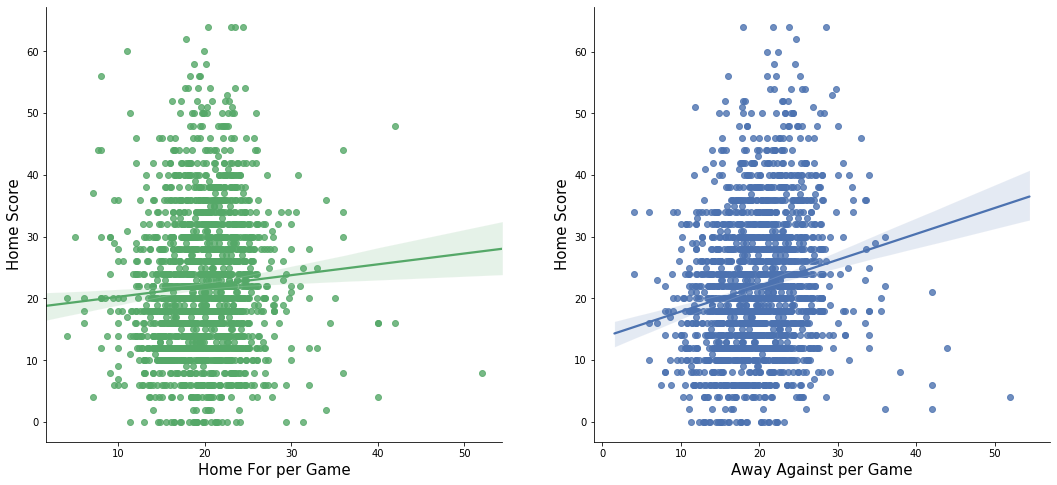

In [23]:
fig, axs = plt.subplots(ncols=2)
sns.set_style('ticks')
sns_plot1 = sns.regplot(pdf['away_against_per_game'], 
            pdf['home_score'], 
            scatter = True, 
            ax=axs[1], 
            label='big')
sns.despine()
sns_plot1.set_xlabel("Away Against per Game",fontsize=15)
sns_plot1.set_ylabel("Home Score",fontsize=15)

sns.set_style('ticks')
fig.set_size_inches(18, 8)
sns_plot2 = sns.regplot(pdf['home_for_per_game'], 
            pdf['home_score'], 
            scatter = True, 
            ax=axs[0], 
            label = 'big')
sns.despine()
sns_plot2.set_xlabel("Home For per Game",fontsize=15)
sns_plot2.set_ylabel("Home Score",fontsize=15)

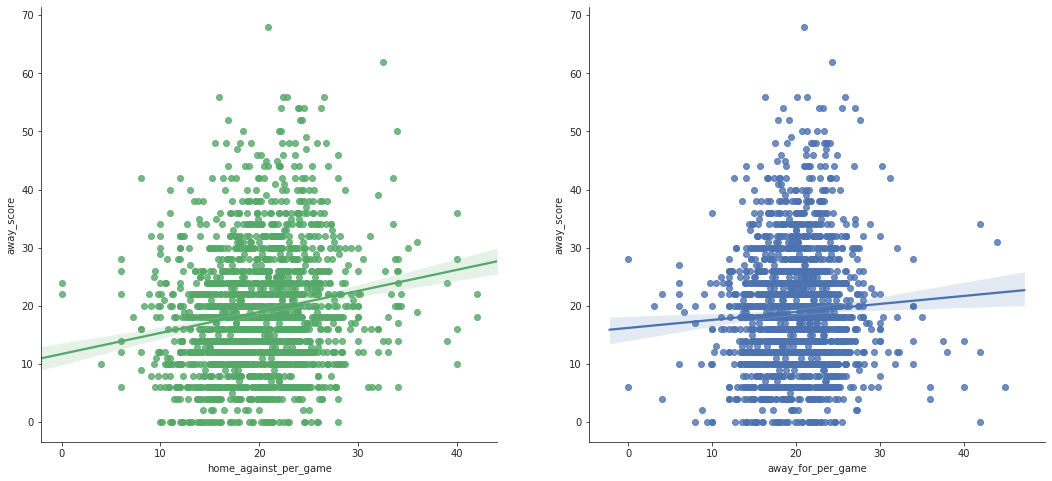

In [24]:
fig, axs = plt.subplots(ncols=2)
sns.set_style('ticks')
fig.set_size_inches(18, 8)
sns.regplot(pdf['away_for_per_game'], 
            pdf['away_score'], 
            scatter = True, 
            ax=axs[1])
sns_plot2.set_xlabel("Away For per Game",fontsize=15)
sns_plot2.set_ylabel("Away Score",fontsize=15)
sns.despine()
sns.set_style('ticks')
fig.set_size_inches(18, 8)
sns.regplot(pdf['home_against_per_game'], 
            pdf['away_score'], 
            scatter = True, 
            ax=axs[0])
sns_plot2.set_xlabel("Home Against per Game",fontsize=15)
sns_plot2.set_ylabel("Away Score",fontsize=15)
sns.despine()

These 4 plots are pretty interesting - they show that the amount of points scored by a particular team has a greater correlation with the opposition's defensive strength rather than their own attacking capabilities

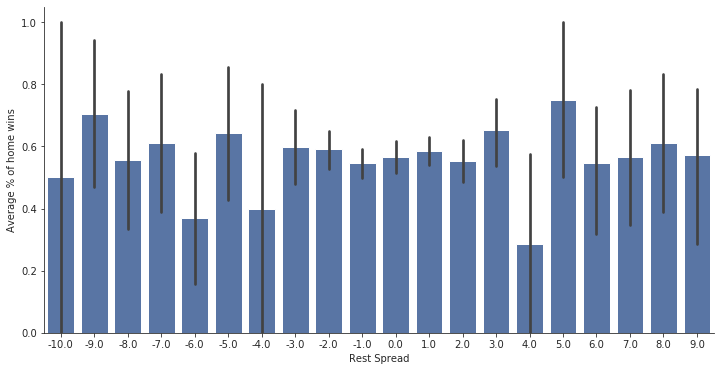

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns1=sns.barplot(x='rest_spread', y='home_win', data=pdf.query('-10 <= rest_spread <= 10'),
            color='#4c72b0', ax=ax)
sns1.set(xlabel = "Rest Spread", ylabel = "Average % of home wins")

sns.despine()

This plot shows that the average percentage of home wins + confidence intervals for differences in rest between the home team and the away team. (E.g. When rest spread is equal to 2, this could mean that the home team had 8 days rest, whilst the away team had 6 days rest)

In [26]:
wins = (
    pd.melt(pdf,
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'is_home'])
   .win
   .agg(['sum', 'count', 'mean'])
)

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.


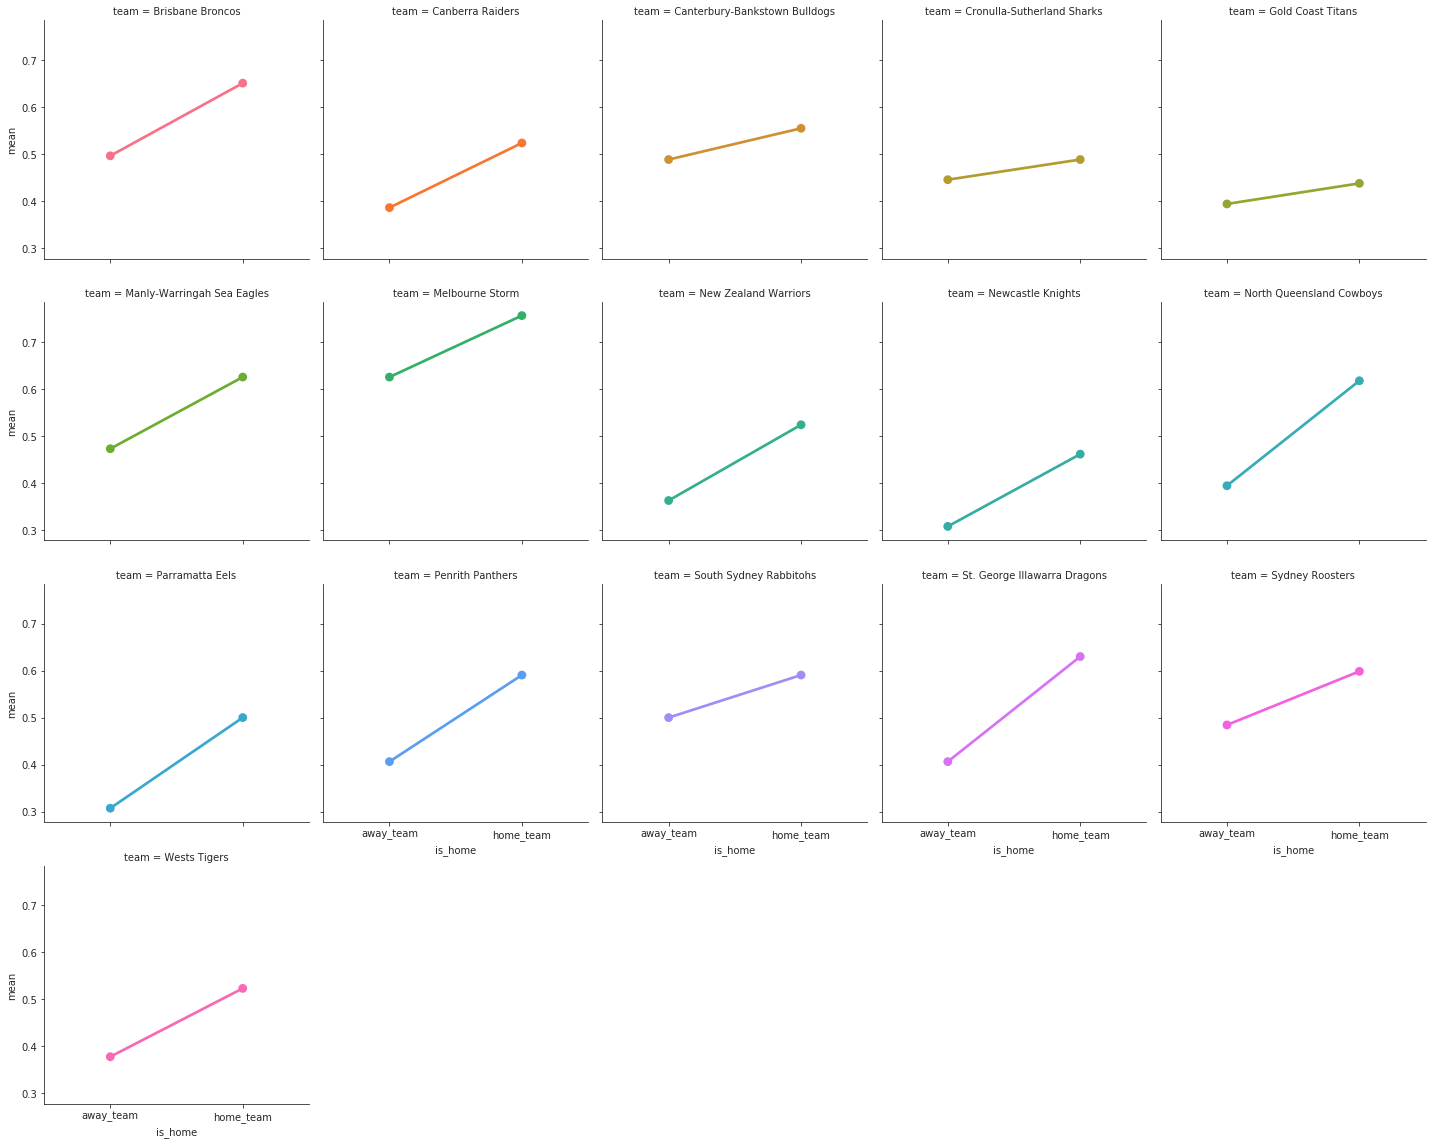

In [27]:
#creates multiple subplots of each team's win pct at home and away from home
g = sns.FacetGrid(wins.reset_index(), col='team', hue='team', col_wrap=5, height=4)
g.map(sns.pointplot, 'is_home', 'mean');

The graph above highlights a few things:
- Titans are shit all the time, however they are only a little bit less shit when playing at home
- Storm are good
- Cowboys are good at home and shit when they're away from home 
- And surprisingly Saints are good at home, but they are also pretty bad when away from home

In [28]:
wins = (
    pd.melt(pdf,
            id_vars=['game_id', 'date', 'home_win', 'day_of_week'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'day_of_week'])
   .win
   .agg(['sum', 'count', 'mean'])
)

wins.columns = ['number_of_wins', 'number_of_games', 'percentage_of_wins']

In [29]:
wins

number_of_wins  number_of_games  \
team                          day_of_week                                    
Brisbane Broncos              Fri                    77.0              134   
                              Mon                     6.0               13   
                              Sat                    25.0               43   
                              Sun                    20.0               32   
                              Thu                    18.0               33   
Canberra Raiders              Fri                    10.0               22   
                              Mon                    15.0               23   
                              Sat                    46.0              107   
                              Sun                    43.0               99   
                              Thu                     2.0                4   
Canterbury-Bankstown Bulldogs Fri                    46.0               86   
                              Mon                    14.0               24   
                              Sat                    33.0               59   
                              Sun                    33.0               62   
                              Thu                     7.0               24   
Cronulla-Sutherland Sharks    Fri                    15.0               27   
                              Mon                    10.0               32   
                              Sat                    50.0              105   
                              Sun                    41.0               83   
                              Thu                     3.0                8   
Gold Coast Titans             Fri                    26.0               54   
                              Mon                    12.0               21   
                              Sat                    32.0              102   
                              Sun                    36.0               76   
                              Thu                     0.0                2   
Manly-Warringah Sea Eagles    Fri                    25.0               52   
                              Mon                    17.0               35   
                              Sat                    48.0               84   
                              Sun                    49.0               77   
                              Thu                     1.0                7   
Melbourne Storm               Fri                    32.0               47   
                              Mon                    19.0               37   
                              Sat                    69.0               97   
                              Sun                    42.0               60   
                              Thu                    11.0               11   
                              Tue                     1.0                1   
                              Wed                     2.0                2   
New Zealand Warriors          Fri                    16.0               30   
                              Mon                     6.0                8   
                              Sat                    47.0              111   
                              Sun                    44.0              101   
                              Thu                     0.0                2   
                              Tue                     0.0                1   
                              Wed                     0.0                2   
Newcastle Knights             Fri                    12.0               38   
                              Mon                    12.0               26   
                              Sat                    35.0               91   
                              Sun                    39.0               99   
                              Thu                     0.0                1   
North Queensland Cowboys      Fri                    20.0        

In [30]:
wins = (
    pd.melt(pdf,
            id_vars=['game_id', 'date', 'home_win', 'night_game'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'night_game'])
   .win
   .agg(['sum', 'count', 'mean'])
)

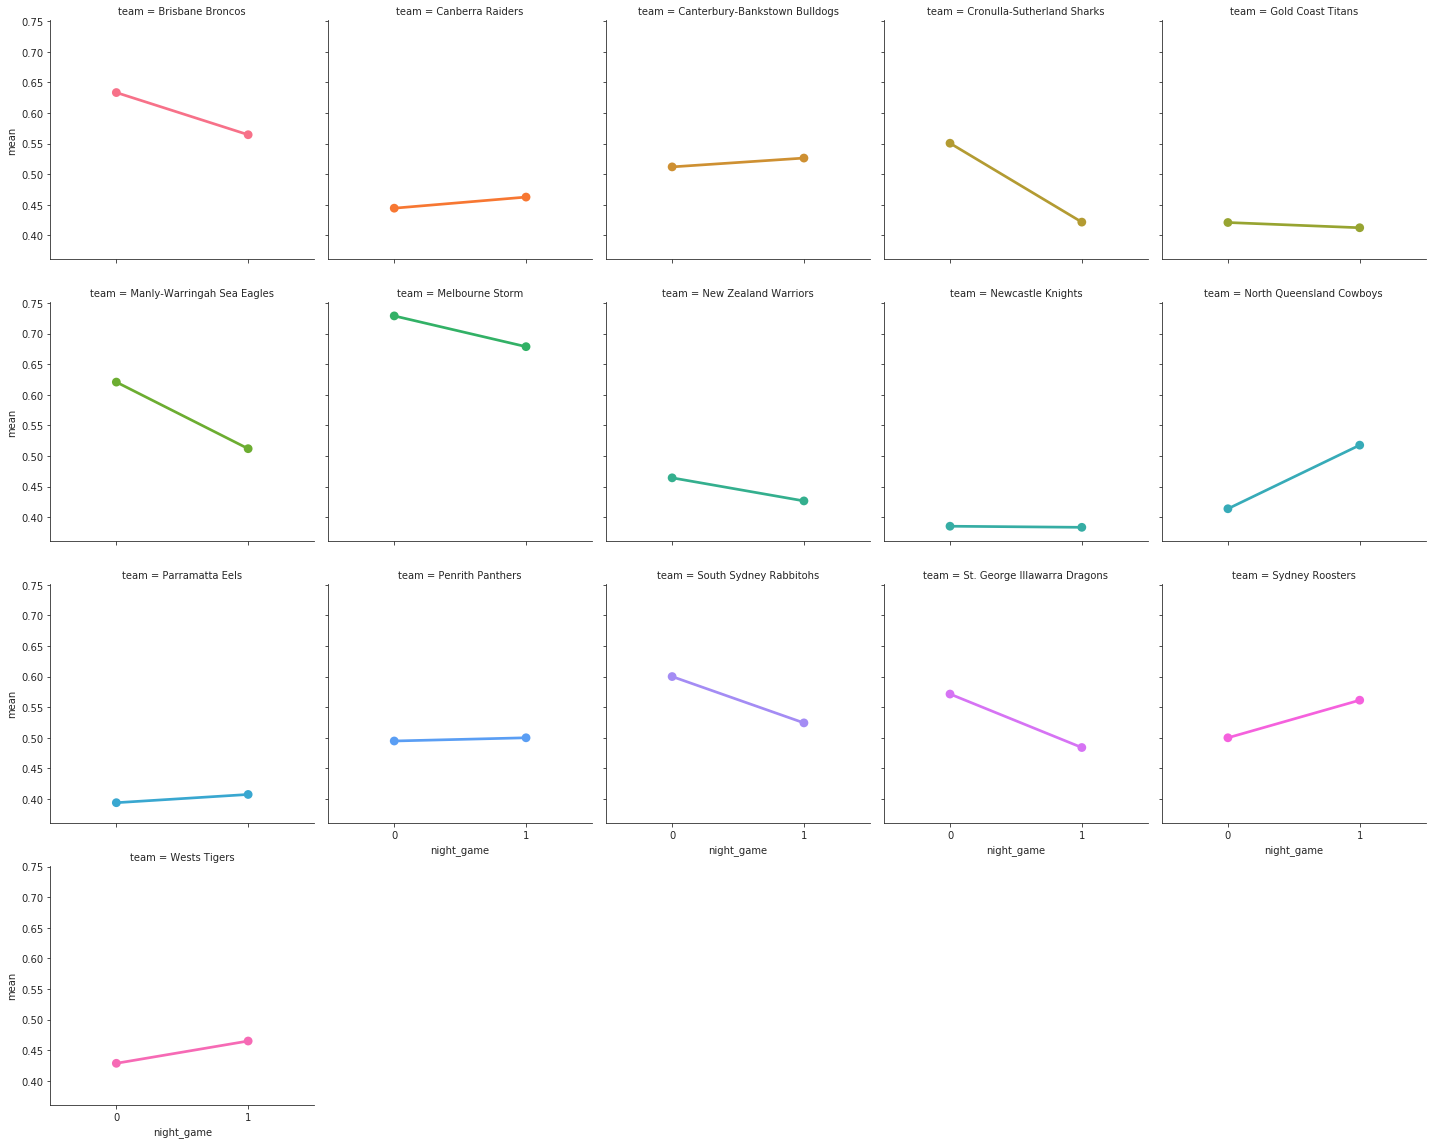

In [31]:
#creates multiple subplots of each team's win pct at day and night games
g = sns.FacetGrid(wins.reset_index(), col='team', hue='team', col_wrap=5, height=4)
g.map(sns.pointplot, 'night_game', 'mean');

Most teams are pretty consistent when playing during the day and night, a few of the outliers though are:
- Cowboys are good when playing at night, but not great during the day
- Tigers are a fraction better during the night which debunks the myth that they are good on a Sunday arvo
- The Sharkies are a lot better when playing during the day rather than at night

(N.B. day games are defined as games played before 5pm, not the greatest definition but oh well)

In [32]:
s = pdf.groupby(["home_team", "away_team"])['margin'].mean().round(2)
s.unstack()

away_team,Brisbane Broncos,Canberra Raiders,Canterbury-Bankstown Bulldogs,Cronulla-Sutherland Sharks,Gold Coast Titans,Manly-Warringah Sea Eagles,Melbourne Storm,New Zealand Warriors,Newcastle Knights,North Queensland Cowboys,Parramatta Eels,Penrith Panthers,South Sydney Rabbitohs,St. George Illawarra Dragons,Sydney Roosters,Wests Tigers
home_team,,,,,,,,,,,,,,,,
Brisbane Broncos,NaN,6.86,7.75,12.00,13.20,12.57,-14.11,-6.50,19.71,4.91,2.56,8.62,2.40,7.90,5.86,12.17
Canberra Raiders,3.78,NaN,2.11,-6.60,4.38,-1.00,-10.20,2.12,6.09,6.82,12.88,3.80,-7.80,4.25,-2.43,-0.67
Canterbury-Bankstown Bulldogs,8.12,-1.57,NaN,5.00,1.00,1.12,6.10,4.43,-2.86,0.25,-1.64,-1.29,-0.27,1.56,7.00,6.67
Cronulla-Sutherland Sharks,-2.50,-6.89,-5.60,NaN,3.22,-8.70,-2.14,3.25,3.60,-6.22,2.12,3.62,2.12,0.10,3.09,-1.43
Gold Coast Titans,-12.20,0.45,-0.83,-0.57,NaN,-3.27,-11.71,-5.45,7.38,2.11,6.44,0.56,-9.00,-6.33,-1.83,1.00
Manly-Warringah Sea Eagles,2.67,6.00,4.91,13.17,2.00,NaN,1.20,5.22,15.50,-4.60,11.10,3.00,-0.89,11.00,-0.67,9.67
Melbourne Storm,11.27,12.25,4.14,14.80,8.33,2.62,NaN,14.27,14.55,11.43,24.86,16.33,16.17,10.25,6.44,3.50
New Zealand Warriors,5.00,6.20,5.43,-6.86,8.18,-8.43,-7.00,NaN,8.36,-1.25,11.71,-0.56,-2.43,-8.78,-5.78,9.00
Newcastle Knights,-2.40,4.62,0.75,-3.80,6.10,1.86,-8.43,-2.88,NaN,4.29,9.60,-1.09,-6.17,-1.60,-3.25,1.50


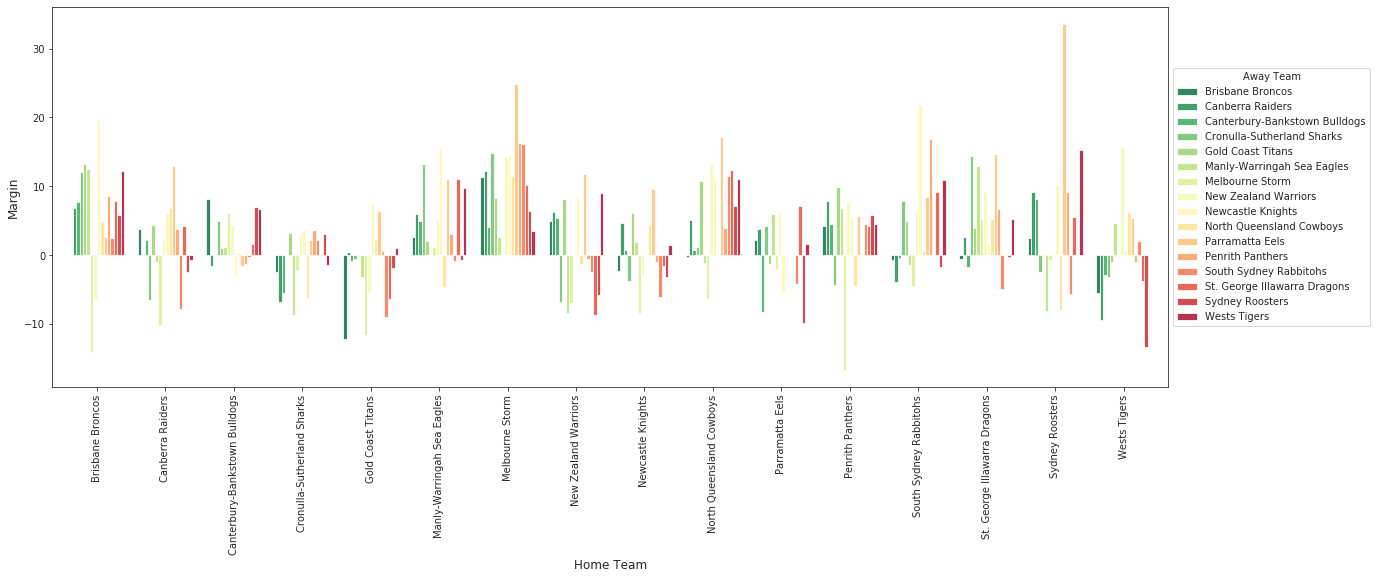

In [33]:
fig = plt.figure()
s.unstack().fillna(0).plot(kind='bar', 
                           ax=fig.gca(),
                           figsize=(20,7), 
                           width=0.8, 
                           alpha=0.8, 
                           rot=0,
                           colormap=cm.RdYlGn_r)
lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Away Team')
plt.xticks(rotation=90)
plt.ylabel("Margin", fontsize=12)
plt.xlabel("Home Team", fontsize=12)
plt.show()

The table and graph above just highlights the average margins by each team against each team, divided by home and away.

In [34]:
s1 = pdf.groupby(["home_position", "away_position"])['margin'].mean().round(2)
s1.unstack()

away_position,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
home_position,,,,,,,,,,,,,,,,
1.0,NaN,1.33,5.60,9.33,7.75,3.10,14.08,10.10,1.71,16.00,19.60,13.00,-12.00,21.50,3.67,25.60
2.0,3.00,NaN,0.50,-1.00,4.17,8.33,12.00,8.29,2.00,10.80,1.14,7.00,9.33,-2.50,13.29,9.11
3.0,3.08,4.67,NaN,6.82,6.25,1.45,-0.82,9.00,18.29,4.12,-2.00,8.82,17.00,8.88,11.00,11.20
4.0,7.43,1.67,-3.22,NaN,10.17,1.89,3.90,1.83,1.60,4.73,5.17,6.67,15.14,17.00,13.20,13.89
5.0,-9.20,0.88,12.50,12.20,NaN,-10.00,8.00,6.50,-1.42,7.56,14.00,0.60,-1.25,11.75,10.22,4.90
6.0,2.50,-3.17,9.00,-3.83,-1.60,NaN,7.86,-2.00,-7.29,0.00,12.50,14.33,4.30,2.86,1.56,3.50
7.0,2.25,0.56,9.44,-10.00,0.86,-0.38,NaN,-1.20,16.00,-11.40,12.58,18.67,16.43,1.50,10.62,6.50
8.0,-3.00,-6.11,3.75,1.20,13.25,9.46,1.71,NaN,0.50,4.00,2.00,7.00,7.25,8.75,9.25,12.25
9.0,4.20,-7.00,7.50,13.60,-6.29,3.27,-1.33,2.50,NaN,1.57,5.07,8.50,6.36,5.79,4.00,10.67


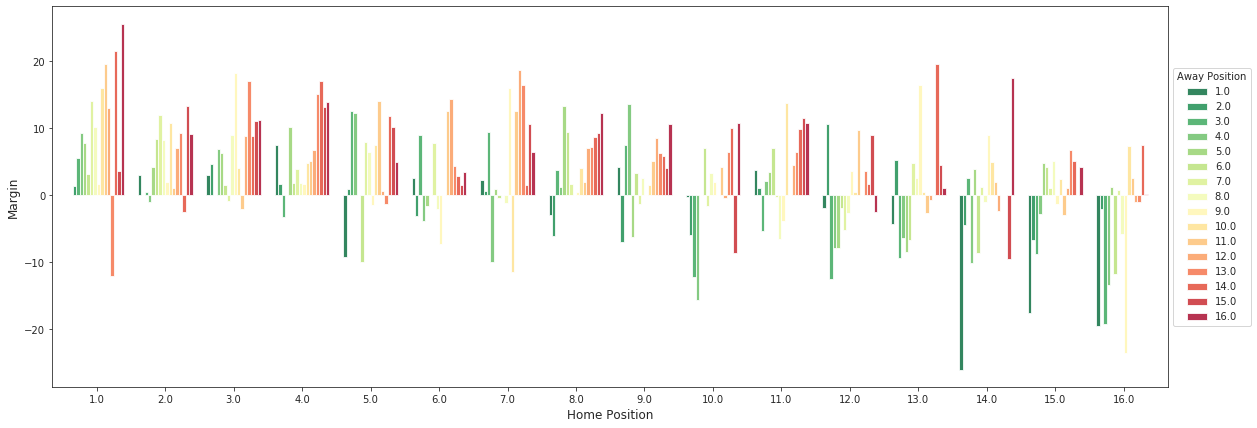

In [35]:
fig = plt.figure()
s1.unstack().fillna(0).plot(kind='bar', 
                            ax=fig.gca(),
                            figsize=(20,7), 
                            width=0.8, 
                            alpha=0.8, 
                            rot=0,
                            colormap=cm.RdYlGn_r)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title = 'Away Position')
plt.ylabel("Margin", fontsize=12)
plt.xlabel("Home Position", fontsize=12)
plt.show()

The table and graph above just highlights the average margins by each position on the ladder, divided by home and away.